<a href="https://colab.research.google.com/github/epigos/house-prices-prediction/blob/main/linear_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq catboost yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [2]:
# some builtin imports
import re
import warnings
from collections import Counter
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Some usual imports here
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# sklearn models
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import metrics, model_selection

# visualizations
import shap
from yellowbrick.regressor import residuals_plot, prediction_error

In [3]:
## Customize Matplotlib Parameters
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
mpl.rcParams['figure.edgecolor']= 'black'
mpl.rcParams['axes.linewidth']= .5
# Customize Seaborn Parameters
sns.set()
rc = {
      'font.family': ['serif'],
      'font.serif':'Times New Roman',
      'grid.color': 'gainsboro',
      'grid.linestyle': '-',
}
sns.set_style(rc=rc)
sns.set_context("notebook", font_scale=0.8)

# Load dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/house_rental_final.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17890 entries, 0 to 17889
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   category_Flats                 17890 non-null  float64
 1   category_Detached              17890 non-null  float64
 2   category_Townhouse             17890 non-null  float64
 3   category_Duplex                17890 non-null  float64
 4   category_Mansion               17890 non-null  float64
 5   category_Semi-Detached         17890 non-null  float64
 6   bedrooms                       17890 non-null  float64
 7   bathrooms                      17890 non-null  float64
 8   floor_area                     17890 non-null  float64
 9   condition_Used                 17890 non-null  float64
 10  condition_New                  17890 non-null  float64
 11  condition_Renovated            17890 non-null  float64
 12  amenities_24-hour electricity  17890 non-null 

# Linear regression

In [6]:
def compute_metrics(model, x, y, cv=5):
    preds = model.predict(x)
    score = model.score(x, y)

    scores_cvs = model_selection.cross_val_score(model, x, y, scoring='r2', cv=cv)

    return pd.DataFrame([{
        "R2": round(score, 3),
        "mse": round(metrics.mean_squared_error(y, preds), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y, preds)), 3),
        "mae": round(metrics.mean_absolute_error(y, preds), 3),
        "adjusted_r2": round(1 - (1 - score) * (len(y) - 1) / (len(y) - x.shape[1] - 1), 3),
        "cv_score": round(scores_cvs.mean()*100, 2)
    }])

In [7]:
# train-test split for model evaluation
X = df.drop(['price', 'log1p_price'], axis=1).values
y = df['log1p_price'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=42
)

In [8]:
X_train.shape, X_test.shape

((14312, 37), (3578, 37))

In [9]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

### Training metrics


In [10]:
train_metrics = compute_metrics(lm, X_train, y_train)
train_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.747,0.327,0.572,0.435,0.746,74.51


### Validation metrics


In [32]:
val_metrics = compute_metrics(lm, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.749,0.331,0.576,0.437,0.746,74.51


# GridSearch

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=10, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)

Best hyperparameters: {'copy_X': True, 'fit_intercept': False, 'positive': False}
Best R2 score: 0.7446535749939428


In [18]:
best_lm = grid_search.best_estimator_
val_metrics = compute_metrics(best_lm, X_test, y_test)
val_metrics

,R2,mse,rmse,mae,adjusted_r2,cv_score
0,0.749,0.331,0.575,0.436,0.746,74.53


### Residual plots

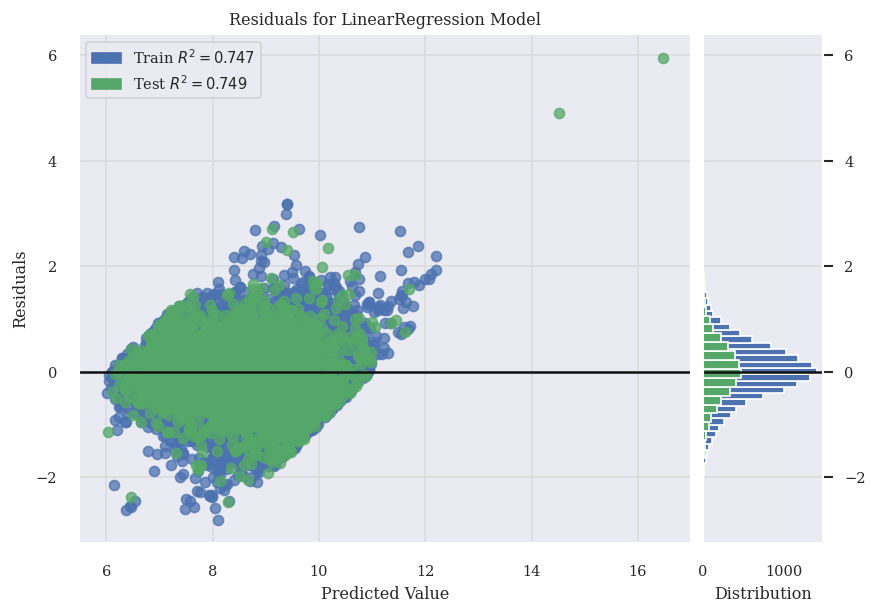

In [19]:
visualizer = residuals_plot(
    best_lm, X_train, y_train, X_test, y_test,
)

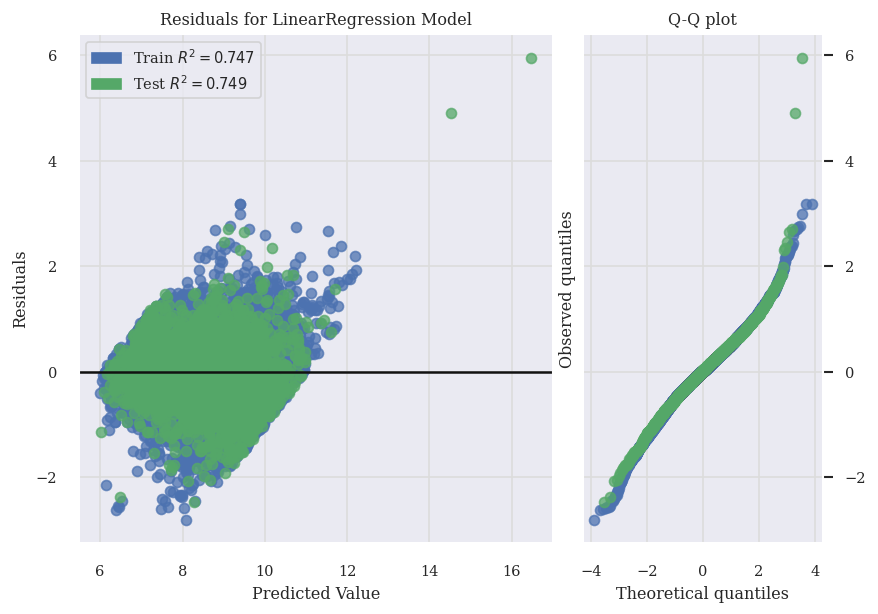

In [20]:
visualizer = residuals_plot(
    best_lm, X_train, y_train, X_test, y_test, hist=False, qqplot=True
)

The QQ-Plot shows the residuals are normally distributed, because their quantiles when plotted against quantiles of normal distribution forms a straight line.

### Prediction Error

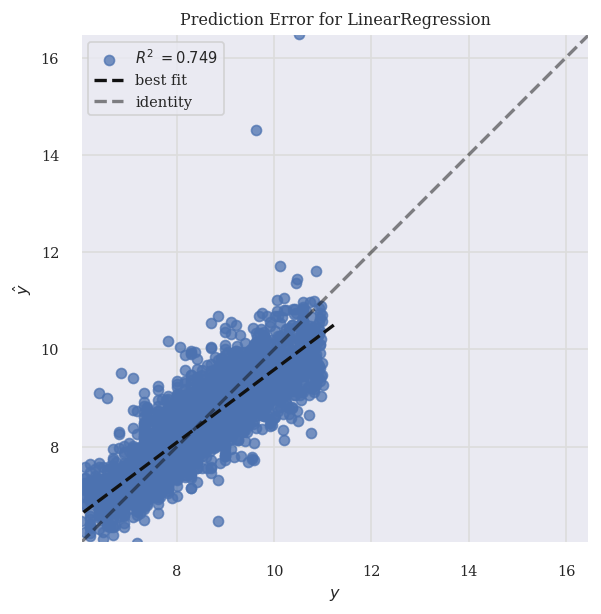

In [21]:
visualizer = prediction_error(best_lm, X_train, y_train, X_test, y_test)

In [23]:
# Create a DataFrame with coefficients and feature names
coef_df = pd.DataFrame({'feature': df.drop(['price', 'log1p_price'], axis=1).columns,
                       'coefficient': best_lm.coef_})

# Sort the DataFrame by the absolute value of coefficients
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

coef_df

,feature,coefficient
11,condition_Renovated,-9.026565e+11
9,condition_Used,-9.026565e+11
10,condition_New,-9.026565e+11
36,furnishing_Furnished,4.935120e+11
35,furnishing_Unfurnished,4.935120e+11
34,furnishing_Semi-Furnished,4.935120e+11
33,amenities_count,-1.753791e+11
13,amenities_air conditioning,4.208720e+10
25,amenities_refrigerator,4.208720e+10
22,amenities_microwave,4.208720e+10


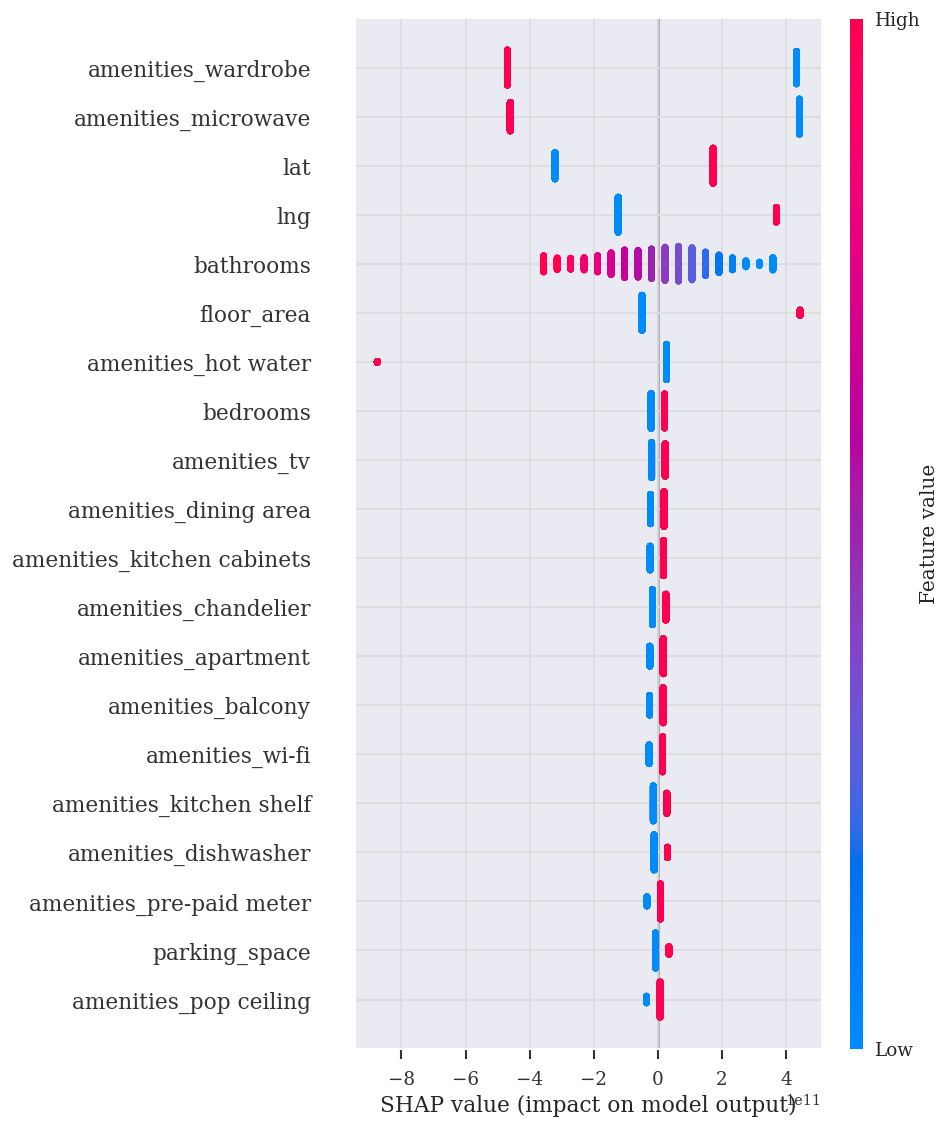

In [24]:
explainer = shap.Explainer(best_lm, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=coef_df['feature'].values)

## Actual Predictions

In [30]:
preds = best_lm.predict(X_test)

In [35]:
# Reverse the log transformation
actual_preds = np.expm1(preds)
actual_y_test = np.expm1(y_test)

# Compute metrics on the original scale
def compute_metrics_original_scale(y_true, y_pred):
    return pd.DataFrame([{
        "R2": round(metrics.r2_score(y_true, y_pred), 3),
        "mse": round(metrics.mean_squared_error(y_true, y_pred), 3),
        "rmse": round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 3),
        "mae": round(metrics.mean_absolute_error(y_true, y_pred), 3),
    }])

val_metrics_original_scale = compute_metrics_original_scale(actual_y_test, actual_preds)
val_metrics_original_scale

,R2,mse,rmse,mae
0,-495.752,5.783117e+10,240481.113,8346.512


In [36]:
pred_df = pd.DataFrame({"actual": actual_y_test, "pred": actual_preds})
pred_df.head(10)

,actual,pred
0,2000.0,2579.158420
1,2500.0,4750.941706
2,1500.0,1155.015405
3,1000.0,1557.820260
4,4000.0,7536.132216
5,3500.0,4229.077468
6,5000.0,4175.714758
7,3000.0,4453.238208
8,8000.0,14740.009815
9,1200.0,1250.668407


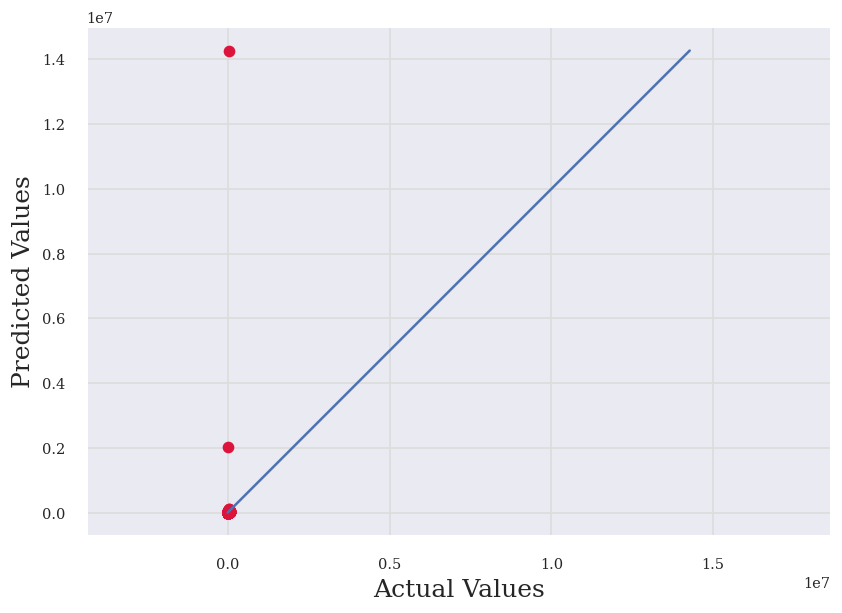

In [37]:
plt.scatter(pred_df.actual, pred_df.pred, c='crimson')
p1 = max(max(pred_df.actual), max(pred_df.pred))
p2 = min(min(pred_df.actual), min(pred_df.pred))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.axis('equal')
plt.show()

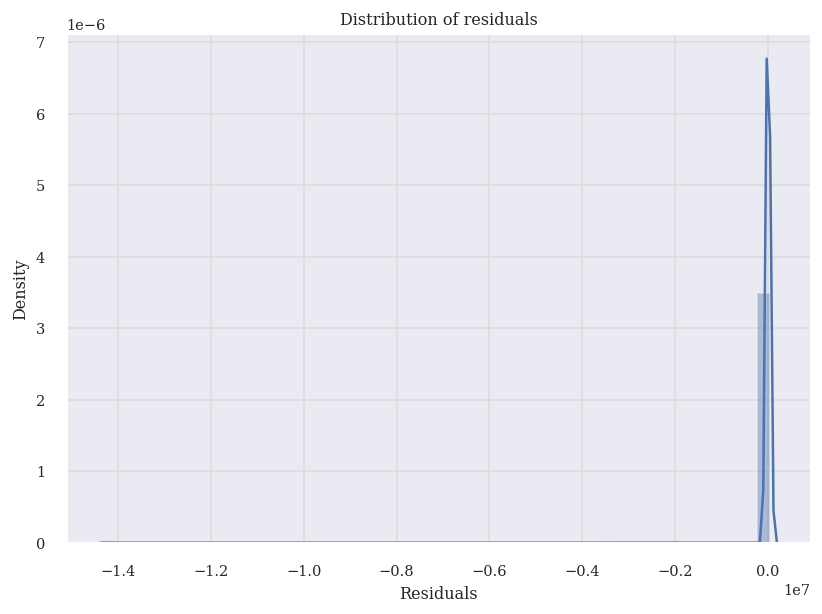

In [38]:
sns.distplot((pred_df.actual-pred_df.pred))
plt.title('Distribution of residuals')
plt.xlabel("Residuals")
plt.show()